## My codes for 100 knocks for image processing (Question 71 through 80)

[https://github.com/yoyoyo-yo/Gasyori100knock](https://github.com/yoyoyo-yo/Gasyori100knock)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('./dataset/images/imori_256x256.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_128 = io.imread('./dataset/images/imori_128x128.png')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('./dataset/images/imori_256x256_noise.png')
img_dark = io.imread('./dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('./dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

img_thorino = io.imread('./dataset/images/thorino.jpg')
img_thorino_gray = cv2.cvtColor(img_thorino, cv2.COLOR_RGB2GRAY)

img_eye = io.imread("./dataset/images/imori_256x256_eye.png")
img_eye = cv2.cvtColor(img_eye, cv2.COLOR_RGBA2RGB)

img_seg = io.imread("./dataset/images/seg_sample.png")
img_connect = io.imread("./dataset/images/connect_sample.png")
img_gazo = io.imread("./dataset/images/gazo_sample.png")


### Question No. 71 マスキング

imori_256x256.png に対して、Q.70のマスク画像を利用してイモリ以外を黒で埋めよ。

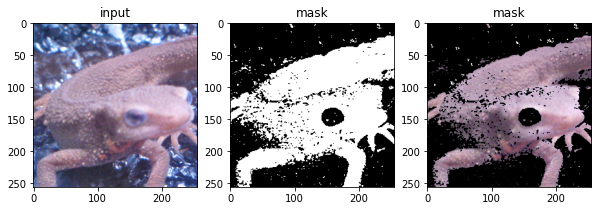

In [2]:
hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)

def get_mask(hsv):
    h = hsv[..., 0]
    mask = np.zeros_like(h).astype(np.uint8)
    mask[((h < 90) | (h > 140))] = 1
    return mask

mask = get_mask(hsv)

img_masked = img_orig.copy() * np.concatenate([mask[..., None], mask[..., None], mask[..., None]], axis=-1)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("mask")
ax[1].imshow(mask, cmap="gray")
ax[2].set_title("mask")
ax[2].imshow(img_masked, cmap="gray")
plt.show()


### Question No. 72 マスキング(カラートラッキング＋モルフォロジー)

Q.71ではマスクが雑になってしまっていたので、イモリの目の部分が削除されていたり、背景がところどころ残ってしまった。

よってマスク画像にクロージング処理とオープニング処理を施して、マスキングを行え。

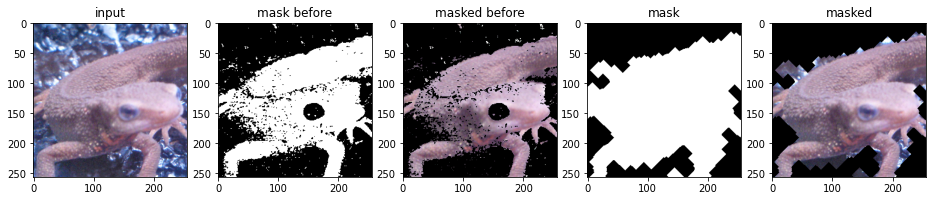

In [3]:
def morphology_erode(img, repeat=1):
    h, w = img.shape
    out = img.copy()

    mf = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=int)

    for i in range(repeat):
        tmp = np.pad(out, (1, 1), 'edge')
        for y in range(1, h + 1):
            for x in range(1, w + 1):
                if np.sum(mf * tmp[y-1:y+2, x-1:x+2]) < 1*4:
                    out[y-1, x-1] = 0

    return out

def morphology_dilate(img, repeat=1):
    h, w = img.shape
    mf = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=int)

    out = img.copy()
    for i in range(repeat):
        tmp = np.pad(out, (1, 1), 'edge')
        for y in range(1, h+1):
            for x in range(1, w+1):
                if np.sum(mf * tmp[y-1:y+2, x-1:x+2]) >= 1:
                    out[y-1, x-1] = 1

    return out

def morphology_open(img, repeat=1):
    out = morphology_dilate(img, repeat=repeat)
    out = morphology_erode(out, repeat=repeat)
    return out

def morphology_close(img, repeat=1):
    out = morphology_erode(img, repeat=repeat)
    out = morphology_dilate(out, repeat=repeat)
    return out


# close and open
mask2 = morphology_open(mask, repeat=10)
mask2 = morphology_close(mask2, repeat=10)

img_masked2 = img_orig.copy() * np.concatenate([mask2[..., None], mask2[..., None], mask2[..., None]], axis=-1)

fig, ax = plt.subplots(1, 5, figsize=(16, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("mask before")
ax[1].imshow(mask, cmap="gray")
ax[2].set_title("masked before")
ax[2].imshow(img_masked)
ax[3].set_title("mask")
ax[3].imshow(mask2, cmap="gray")
ax[4].set_title("masked")
ax[4].imshow(img_masked2)
plt.show()


### Question No. 73 縮小と拡大

グレースケールを0.5倍に縮小した後に2倍に拡大した画像を求めよ。 この処理を行うと、ぼやけた画像ができる。

拡大縮小にはbi-linear補間を用いよ。bi-linear補間をメソッド（関数）化すると、プログラムが簡潔にできる。



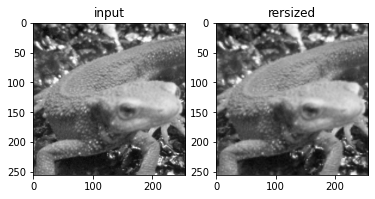

In [17]:
def bilinear_inter_gray(img, a, b):
    h, w = img.shape
    out_h = int(h * a)
    out_w = int(w * b)

    xs, ys = np.meshgrid(range(out_w), range(out_h)) # output image index

    _xs = np.floor(xs / b).astype(int) # original x
    _ys = np.floor(ys / a).astype(int) # original y

    dx = xs / b - _xs
    dy = ys / a - _ys

    # dx = np.repeat(np.expand_dims(dx, axis=-1), c, axis=-1) # repeat channel
    # dy = np.repeat(np.expand_dims(dy, axis=-1), c, axis=-1) # repeat channel

    _xs1p = np.minimum(_xs + 1, w - 1)
    _ys1p = np.minimum(_ys + 1, h - 1)
    
    out = (1 - dx) * (1 - dy) * img[_ys, _xs] + dx * (1 - dy) * img[_ys, _xs1p] + \
                    (1 - dx) * dy * img[_ys1p, _xs] + dx * dy * img[_ys1p, _xs1p]

    return np.clip(out, 0, 255).astype(np.uint8)

img_resized = bilinear_inter_gray(img_gray, a=0.5, b=0.5)
img_resized = bilinear_inter_gray(img_resized, a=2, b=2)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_gray, cmap="gray")
ax[1].set_title("rersized")
ax[1].imshow(img_resized, cmap="gray")
plt.show()


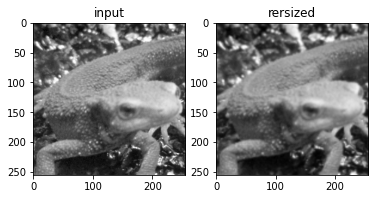

In [23]:
img_resized = cv2.resize(img_gray, (img_gray.shape[0] // 2, img_gray.shape[1] // 2), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.resize(img_resized, (img_resized.shape[0] * 2, img_resized.shape[1] * 2), interpolation=cv2.INTER_LINEAR)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_gray, cmap="gray")
ax[1].set_title("rersized")
ax[1].imshow(img_resized, cmap="gray")
plt.show()

### Question No. 74 ピラミッド差分による高周波成分の抽出

Q.73で求めた画像と元画像の差分を求めよ。

ここで求めた画像はエッジとなっている。つまり、画像中の高周波成分をとったことになる。

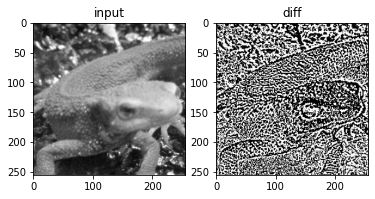

In [24]:
img_diff = np.abs(img_gray - img_resized)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_gray, cmap="gray")
ax[1].set_title("diff")
ax[1].imshow(img_diff, cmap="gray")
plt.show()


### Question No. 75 ガウシアンピラミッド

ここでは、元画像を1/2, 1/4, 1/8, 1/16, 1/32にリサイズした画像を求めよ。

このように元画像を小さくリサイズして重ねたものをガウシアンピラミッドと呼ぶ。

このガウシアンピラミッドの概念は現在でも有効であり、画像をきれいにする超解像を行うディープラーニングの手法でもガウシアンピラミッドの概念が用いられる。



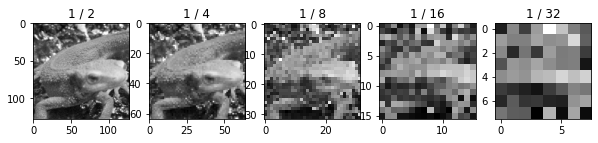

In [25]:
pyramid = [img_gray]

fig, ax = plt.subplots(1, 5, figsize=(10, 4))
for i in range(1, 6):
    img_resized = bilinear_inter_gray(img_gray, a=1. / 2 ** i, b=1. / 2 ** i)
    pyramid.append(img_resized)
    ax[i - 1].set_title(f"1 / {2 ** i}")
    ax[i - 1].imshow(img_resized, cmap='gray')


### Question No. 76 顕著性マップ

ここではガウシアンピラミッドを用いた簡単な顕著性マップを作成する。

顕著性マップとは画像の中で人間の目を引きやすい領域を表した画像である。

Ittiらの手法 ( https://www.sciencedirect.com/science/article/pii/S0042698999001637 )をはじめ、様々な手法が提案されている。

現在ではディープラーニングによる顕著性マップがよく用いられるが、本来は画像のRGB成分やHSV成分などのガウシアンピラミッドを作成し、それらの差分から求める手法がよく用いられた(例えばIttiらの手法などがある)。

ここではIttiらの手法を参考にガウシアンピラミッドから簡単な顕著性マップを作成する。 アルゴリズムは、

ガウシアンピラミッドを元のサイズにリサイズせよ。（リサイズはbi-linear補間を使う）
作成したピラミッドの２つを選び差分を求める。
求めた差分を全て足し合わせ、[0, 255]に正規化する。
以上で顕著性マップが求められる。

イモリの目の部分や色が周辺と極端に違う部分など、人の目に止まりやすい領域が白くなっているのが分かる。


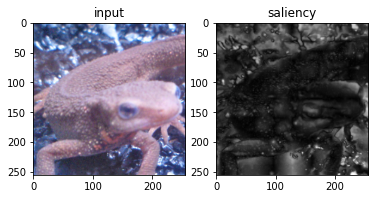

In [30]:
sal = np.zeros_like(img_gray, dtype=np.float32)

pyramid = [img_gray.astype(np.float32)]

for i in range(1, 6):
    img_resized = bilinear_inter_gray(img_gray, a=1. / 2 ** i, b=1. / 2 ** i)
    img_resized = bilinear_inter_gray(img_resized, a=2 ** i, b=2 ** i)
    pyramid.append(img_resized.astype(np.float32))

pyramid_n = len(pyramid)

for i in range(pyramid_n):
    for j in range(i + 1, pyramid_n):
        if i == j:
            continue
        sal += np.abs(pyramid[i] - pyramid[j])
        
sal /= sal.max()
sal *= 255
sal = sal.astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("saliency")
ax[1].imshow(sal, cmap="gray")
plt.show()


### Question No. 77 ガボールフィルタ

ガボールフィルタを実装せよ。

ガボールフィルタとはガウス分布と周波数変換を合わせたフィルタであり、画像の特定方向のみのエッジを抽出する時に使われる。

フィルタは次式で定義される。
```
G(y, x) = exp(-(x'^2 + g^2 y'^2) / 2 s^2) * cos(2 pi x' / l + p)
x' = cosA * x + sinA * y
y' = -sinA * x + cosA * y
```
- y, x はフィルタの位置　フィルタサイズがKとすると、 y, x は [-K//2, k//2]　の値を取る。
- g ... gamma ガボールフィルタの楕円率
- s ... sigma ガウス分布の標準偏差
- l ... lambda 周波数の波長
- p ... 位相オフセット
- A ... フィルタの回転　抽出したい角度を指定する。

ここでは、K=111, s=10, g = 1.2, l =10, p=0, A=0としてガボールフィルタを可視化せよ。

ガボールフィルタを実際に使う時は、フィルタ値の絶対値の和が1になるように正規化すると使いやすくなる。



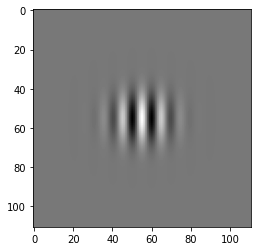

In [31]:
def gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# get gabor kernel
gabor = gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0)

plt.imshow(gabor, cmap="gray")
plt.show()


### Question No. 78 ガボールフィルタの回転

ここでは A=0, 45, 90, 135として回転方向のガボールフィルタを求めよ。 その他のパラメータはQ.77同様、K=111, s=10, g = 1.2, l =10, p=0とせよ。

ここではガボールフィルタをメソッド化すれば簡単に実装できる。

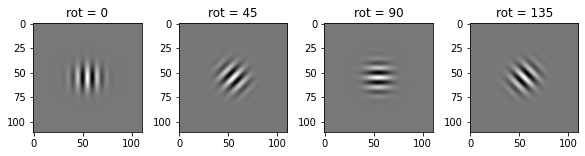

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2))

for i, a in enumerate([0, 45, 90, 135]):
    gabor = gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=a)
    ax[i].set_title(f"rot = {a}")
    ax[i].imshow(gabor, cmap='gray')

plt.show()


### Question No. 79 ガボールフィルタによるエッジ抽出

グレースケールに対し、A=0, 45, 90, 135 のガボールフィルタでフィルタリングせよ。

パラメータはK=11, s=1.5, g=1.2, l=3, p=0とする。

解答例の様に、ガボールフィルタで指定した方向のエッジが抽出できていることが分かる。 このようにガボールフィルタはエッジの特徴抽出に優れている。

ガボールフィルタは生物の視神経における脳内の一次視覚野(V1)での働きに近いとされていて、つまり生物が見ている時の眼の前の画像の特徴抽出を再現しているともいわれる。

ディープラーニングのConvolutional layerはガボールフィルタの働きに近いとも考えられている。しかし、ディープラーニングではフィルタの係数が機械学習によって自動的に決定される。機械学習の結果、ガボールフィルタに近い働きが生じると言われる。

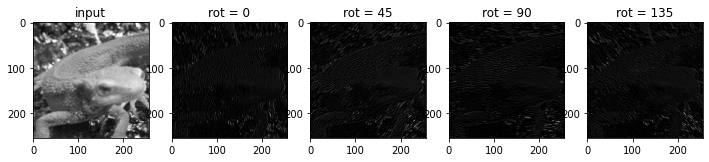

In [33]:
def gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    H, W = gray.shape
    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)
        
    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


fig, ax = plt.subplots(1, 5, figsize=(12, 4))

ax[0].set_title("input")
ax[0].imshow(img_gray, cmap="gray")

for i, a in enumerate([0, 45, 90, 135]):
    img_gabor = gabor_filtering(img_gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, Psi=0, angle=a)
    ax[i + 1].set_title(f"rot = {a}")
    ax[i + 1].imshow(img_gabor, cmap='gray')

plt.show()


### Question No. 80 ガボールフィルタによる特徴抽出

Q.79で求めた４枚の画像を足し合わせることで、画像の特徴を抽出せよ。

結果を見ると、画像の輪郭部分が白くなっていることからエッジ検出のような出力を得たように見える。

ディープラーニングのCNN(Convolutional Neural Network)では、最初に画像の特徴を抽出する働きが備わっているが、その特徴抽出の計算はこの問で行ったような操作を延々と繰り返している。ディープラーニングではこのようにして画像の特徴を自動的に抽出している。

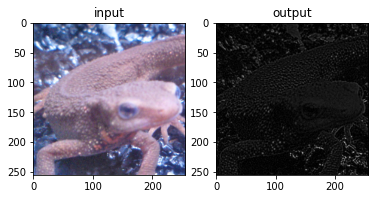

In [34]:
out = np.zeros_like(img_gabor, dtype=np.float32)

for i, a in enumerate([0, 45, 90, 135]):
    img_gabor = gabor_filtering(img_gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, Psi=0, angle=a)
    out += img_gabor.astype(np.float32)
    
out = out / out.max() * 255
out = out.astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(out, cmap="gray")
plt.show()
